# Set-up

### Imports

In [31]:
import math
import random
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TextClassificationPipeline
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

device = torch.device("cpu")

# Set folders
dir_models = Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\models')
dir_data = Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\data')

### Model configs

In [2]:
models = {
    'bert_base_full': { # Base BERT model on full original dataset, reproduced from Luo et al.
        'output_name': 'bert_base_full',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': None,
        'dataset_type': 'orig',
    },   
    'bert_base_reduc': { # Base BERT model on reduced dataset (corresponding to samples available in augm. dataset)
        'output_name': 'bert_base_reduc',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': None,
        'dataset_type': 'reduc',
    },  
    'bert_aug_before': { # Model on augmented dataset, using '[CLS] context [SEP] sentence [SEP]' structure
        'output_name': 'bert_aug_before',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': 'before',
        'dataset_type': 'aug_before',
    },  
    'bert_aug_after': { # Model on augmented dataset, using '[CLS] sentence [SEP] context [SEP]' structure
        'output_name': 'bert_aug_after',
        'ckpt': "google-bert/bert-base-uncased",
        'context_type': 'after',
        'dataset_type': 'aug_after',
    },   
    'droberta_base': { # Base distilRoBERTa model to compare against Climate-model
        'output_name': 'droberta_base',
        'ckpt': "distilbert/distilroberta-base",
        'context_type': None,
        'dataset_type': 'orig',
    },      
    'droberta_climate': { # Climate model on full original dataset
        'output_name': 'droberta_climate',
        'ckpt': "climatebert/distilroberta-base-climate-f",
        'context_type': None,
        'dataset_type': 'orig',
    },
}

### Global definitions and functions

In [3]:
# Define label dictionary for HuggingFace model config.json
label_names = ['disagree', 'agree', 'neutral']
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

def total_steps(config) -> int:
    """Calculate total n steps of trainig config, based on n_epochs, n_samples and batch_size."""
    n_samples = len(config['dataset_enc']['train'])
    n_epochs = 7
    batch_size = 16

    steps_per_epoch = math.ceil(n_samples / batch_size)
    total_steps = steps_per_epoch * n_epochs

    return total_steps

def set_deterministic(seed:int) -> None:
    """Set random seed and disable deterministic algorithms for reproducability of results"""
    random.seed(int(seed))
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(mode=True) # mode=True -> throw runtime error if deterministic alternative not available
   
def get_y_pred(model_name:str, folder_path, subset:str = 'test'):
    """Return predicted y values on set for given model_name in given folder_path."""
    
    model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(folder_path)

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    preds = pipe(models[model_name]['dataset_enc'][subset]['sentence'])

    return np.array([label2id[pred['label']] for pred in preds])

def get_y_true(model_name:str, subset:str = 'test'):
    """Return true y values on set for given model_name"""

    return np.array(models[model_name]['dataset_enc'][subset]['label'])

### Datasets

In [4]:
data_file = dir_data / 'articles.pkl'

# Import and modify pandas dataframe
data_df = pd.read_pickle(data_file)

# Construct multiple context types
def get_context(row: pd.Series, context_type: str):
    if context_type == 'before':
        return f"{row['title']} : {row['sent-5']} {row['sent-4']} {row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent0']}"
    elif context_type == 'after':
        return f"{row['sent0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']} {row['sent+5']}"
    else:
        return ''

for context_type in ['context_before', 'context_after']:
    data_df[context_type] = data_df.apply(lambda row: get_context(row, context_type), axis=1)

# Split train-test
data_df_train = data_df[data_df['in_held_out_test'] == False].reset_index(drop=True)
data_df_test = data_df[data_df['in_held_out_test'] == True].reset_index(drop=True)  # test_set defined by Luo et al. and used for human baseline

# Select reduced size dataset (based on available samples for augmented dataset)
data_df_train_reduc = data_df_train[data_df_train['ok'] == True].reset_index(drop=True)
data_df_test_reduc = data_df_test[data_df_test['ok'] == True].reset_index(drop=True)

# Change dataframe to Transformers dataset type

# Define dataset features
features_dict = {
    'orig': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'reduc': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_before': Features({'sentence': Value('string'),
                            'context_before': Value('string'),
                            'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_after': Features({'sentence': Value('string'),
                            'context_after': Value('string'),
                            'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
}

# Create dataset variants
datasets = {
    'orig': DatasetDict({
        'train': Dataset.from_pandas(data_df_train[['label', 'sentence']], features=features_dict['orig']),
        'test': Dataset.from_pandas(data_df_test[['label', 'sentence']], features=features_dict['orig'])
    }),
    'reduc': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'sentence']], features=features_dict['reduc']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'sentence']], features=features_dict['reduc'])
    }),
    'aug_before': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before', 'sentence']], features=features_dict['aug_before']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'context_before', 'sentence']], features=features_dict['aug_before'])
    }),
    'aug_after': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_after', 'sentence']], features=features_dict['aug_after']),
        'test': Dataset.from_pandas(data_df_test_reduc[['label', 'context_after', 'sentence']], features=features_dict['aug_after'])
    }),
}

In [5]:
# This comparison shows that the proportion of test samples in the reduced dataset is similar, which is good.
print(data_df['in_held_out_test'].value_counts(normalize=True))
print(data_df[data_df['ok'] == True]['in_held_out_test'].value_counts(normalize=True))

in_held_out_test
False    0.902439
True     0.097561
Name: proportion, dtype: float64
in_held_out_test
False    0.900592
True     0.099408
Name: proportion, dtype: float64


### Tokenization

In [ ]:
# Luo et al. note using a max_seq_length=256 (but don't expalain why) in Appendix H (p. 3312). They truncate all characters after it.
# can be found in...
# model_base.config.max_position_embeddings (default = 512)

In [52]:
# experimenting with output of full context in structure: [CLS] preced. context, sentence, postced. context [SEP]

config = models['bert_base_full']

output = datasets[config['dataset_type']].map(lambda batch: config['tokenizer'](text=batch["sentence"], padding=True, truncation=True), batched=True, batch_size=None)

output['train']['input_ids'][0]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

[101,
 16676,
 1011,
 2084,
 1011,
 3671,
 2712,
 3302,
 7715,
 2024,
 1037,
 3145,
 2447,
 1999,
 1996,
 2458,
 1997,
 17035,
 2107,
 2004,
 16864,
 1998,
 3565,
 19718,
 7525,
 1010,
 2029,
 2718,
 1996,
 1057,
 1012,
 1055,
 1012,
 2264,
 3023,
 1999,
 2249,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
# Get tokenizers
for model, config in models.items():
    models[model]['tokenizer'] = AutoTokenizer.from_pretrained(config['ckpt'])

# Define tokenizer variants (for incorporating context)
def tokenize(batch, tokenizer, context=None):
    if context == None:
        return tokenizer(batch["sentence"], padding=True, truncation=True)
    elif context =='before':
        return tokenizer(text=batch["context_before"], text_pair=batch["sentence"], padding=True, truncation=True)
    elif context == 'after':
        return tokenizer(text=batch["sentence"], text_pair=batch["context_after"], padding=True, truncation=True)
    elif context == 'full':
        return tokenizer(text=batch["sentence"], padding=True, truncation=True)

# Tokenize
for model, config in models.items():
    models[model]['dataset_enc'] = datasets[config['dataset_type']].map(lambda batch: tokenize(batch, config['tokenizer'], config['context_type']), batched=True, batch_size=None)

# Encode data for PyTorch
for model, config in models.items():
    if config['context_type'] == 'before' or config['context_type'] == 'after':
        models[model]['dataset_enc'].set_format("torch", columns = ["input_ids", "attention_mask", "label", "token_type_ids"])
    else:
        models[model]['dataset_enc'].set_format("torch", columns = ["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

# Training

##### Set-up

In [9]:
def compute_metrics(pred) -> dict:
    """Get metrics for evaluation of Transformers Trainer"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return { "accuracy": accuracy_score(labels, preds),
             "f1": f1_score(labels, preds, average="macro")}

def get_training_args(output_name: str) -> TrainingArguments:
    """ Get Transformers TrainingArgs object. 'output_name' is used for output_dir."""
    return TrainingArguments(
        output_dir = dir_models / output_name,
        num_train_epochs = 7,
        learning_rate = 2e-5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        adam_epsilon = 1e-6,
        warmup_steps = 0,
        evaluation_strategy = 'epoch',
        logging_strategy = 'epoch',
        save_strategy = 'epoch',
        save_total_limit = 5,
        metric_for_best_model = 'f1',
        load_best_model_at_end = True)

def init_trainer(model, args: TrainingArguments, dataset: DatasetDict, tokenizer) -> Trainer:
    """Initialize Transformers Trainer object"""
    return Trainer(model=model, args=args,
                   compute_metrics=compute_metrics,
                   train_dataset = dataset['train'],
                   eval_dataset = dataset['test'],
                   tokenizer=tokenizer)

def train_model(model_name: str, output_name: str = None) -> None:
    """Train model according to specified configuration in 'models' dict."""
    config = models[model_name]

    config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3, id2label=id2label, label2id=label2id).to(device)
    config['train_args'] = get_training_args(output_name or config['output_name'])
    config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
    config['trainer'].train()

##### Train all model configurations

In [ ]:
for model_name in models.keys():
    train_model(model_name)

##### Train individually

###### BERT base full

In [ ]:
train_model('bert_base_full')

###### BERT base reduced

In [ ]:
train_model('bert_base_reduc')

###### Augmented before

In [ ]:
train_model('bert_aug_before')

###### Augmented after

In [ ]:
train_model('bert_aug_after')

###### DistilRoBERTa base

In [ ]:
train_model('droberta_base')

###### BERT base full

In [ ]:
train_model('droberta_climate')

###### DRoBERTa Climate

In [ ]:
train_model('droberta_climate')

In [ ]:
config = models['droberta_climate']

config['model'] = AutoModelForSequenceClassification.from_pretrained(config['ckpt'], num_labels=3).to(device)
config['train_args'] = get_training_args(config['output_name'])
config['trainer'] = init_trainer(config['model'], config['train_args'], config['dataset_enc'], config['tokenizer'])
config['trainer'].train()

# on may 15th, best epoch was 5 (checkpoint-580)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519
7,0.123700,0.803689,0.760000,0.758683


### Test reproducability of deterministic mode

##### Train two models which should be identical

In [10]:
seed = 10

for rep in ['a', 'b']:

    set_deterministic(seed)    

    output_name = f"reprod_test_{rep}"

    train_model('bert_base_full', f"reprod_test_{rep}")   

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

{'loss': 0.9336, 'grad_norm': 9.037306785583496, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8011453151702881, 'eval_accuracy': 0.665, 'eval_f1': 0.6229147847034026, 'eval_runtime': 10.9643, 'eval_samples_per_second': 18.241, 'eval_steps_per_second': 1.186, 'epoch': 1.0}
{'loss': 0.6906, 'grad_norm': 16.29567527770996, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7684459090232849, 'eval_accuracy': 0.705, 'eval_f1': 0.6904723656530886, 'eval_runtime': 9.6515, 'eval_samples_per_second': 20.722, 'eval_steps_per_second': 1.347, 'epoch': 2.0}
{'loss': 0.4391, 'grad_norm': 16.889978408813477, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7554223537445068, 'eval_accuracy': 0.715, 'eval_f1': 0.6966866105533582, 'eval_runtime': 9.6422, 'eval_samples_per_second': 20.742, 'eval_steps_per_second': 1.348, 'epoch': 3.0}
{'loss': 0.2574, 'grad_norm': 8.795279502868652, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9092954397201538, 'eval_accuracy': 0.69, 'eval_f1': 0.6772427983539094, 'eval_runtime': 9.4187, 'eval_samples_per_second': 21.234, 'eval_steps_per_second': 1.38, 'epoch': 4.0}
{'loss': 0.15, 'grad_norm': 32.10765075683594, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.0618139505386353, 'eval_accuracy': 0.695, 'eval_f1': 0.6824981844589688, 'eval_runtime': 9.4991, 'eval_samples_per_second': 21.055, 'eval_steps_per_second': 1.369, 'epoch': 5.0}
{'loss': 0.0827, 'grad_norm': 1.2521156072616577, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.1982437372207642, 'eval_accuracy': 0.695, 'eval_f1': 0.6825877088147027, 'eval_runtime': 9.4705, 'eval_samples_per_second': 21.118, 'eval_steps_per_second': 1.373, 'epoch': 6.0}
{'loss': 0.0594, 'grad_norm': 0.12931589782238007, 'learning_rate': 0.0, 'epoch': 7.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.2174925804138184, 'eval_accuracy': 0.69, 'eval_f1': 0.6746074339971982, 'eval_runtime': 9.5062, 'eval_samples_per_second': 21.039, 'eval_steps_per_second': 1.368, 'epoch': 7.0}
{'train_runtime': 3289.0825, 'train_samples_per_second': 3.937, 'train_steps_per_second': 0.247, 'train_loss': 0.37325991609413633, 'epoch': 7.0}


c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

{'loss': 0.9336, 'grad_norm': 9.037306785583496, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.8011453151702881, 'eval_accuracy': 0.665, 'eval_f1': 0.6229147847034026, 'eval_runtime': 9.9724, 'eval_samples_per_second': 20.055, 'eval_steps_per_second': 1.304, 'epoch': 1.0}
{'loss': 0.6906, 'grad_norm': 16.29567527770996, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7684459090232849, 'eval_accuracy': 0.705, 'eval_f1': 0.6904723656530886, 'eval_runtime': 9.7295, 'eval_samples_per_second': 20.556, 'eval_steps_per_second': 1.336, 'epoch': 2.0}
{'loss': 0.4391, 'grad_norm': 16.889978408813477, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.7554223537445068, 'eval_accuracy': 0.715, 'eval_f1': 0.6966866105533582, 'eval_runtime': 9.7715, 'eval_samples_per_second': 20.468, 'eval_steps_per_second': 1.33, 'epoch': 3.0}
{'loss': 0.2574, 'grad_norm': 8.795279502868652, 'learning_rate': 8.571428571428571e-06, 'epoch': 4.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.9092954397201538, 'eval_accuracy': 0.69, 'eval_f1': 0.6772427983539094, 'eval_runtime': 9.7516, 'eval_samples_per_second': 20.509, 'eval_steps_per_second': 1.333, 'epoch': 4.0}
{'loss': 0.15, 'grad_norm': 32.10765075683594, 'learning_rate': 5.7142857142857145e-06, 'epoch': 5.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.0618139505386353, 'eval_accuracy': 0.695, 'eval_f1': 0.6824981844589688, 'eval_runtime': 9.7072, 'eval_samples_per_second': 20.603, 'eval_steps_per_second': 1.339, 'epoch': 5.0}
{'loss': 0.0827, 'grad_norm': 1.2521156072616577, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.1982437372207642, 'eval_accuracy': 0.695, 'eval_f1': 0.6825877088147027, 'eval_runtime': 12.4647, 'eval_samples_per_second': 16.045, 'eval_steps_per_second': 1.043, 'epoch': 6.0}
{'loss': 0.0594, 'grad_norm': 0.12931589782238007, 'learning_rate': 0.0, 'epoch': 7.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.2174925804138184, 'eval_accuracy': 0.69, 'eval_f1': 0.6746074339971982, 'eval_runtime': 12.9517, 'eval_samples_per_second': 15.442, 'eval_steps_per_second': 1.004, 'epoch': 7.0}
{'train_runtime': 62594.0824, 'train_samples_per_second': 0.207, 'train_steps_per_second': 0.013, 'train_loss': 0.37325991609413633, 'epoch': 7.0}


##### Evaluate if the models have equal parameters

In [30]:
config = models['bert_base_full']

folder_path_a = dir_models / 'reprod_test_a' / f'checkpoint-{total_steps(config)}'
folder_path_b = dir_models / 'reprod_test_b' / f'checkpoint-{total_steps(config)}'

if not folder_path_a.exists() or not folder_path_b.exists():
    raise FileNotFoundError("At least one folder does not exist. Do the models exist in that folder?")

model_a = AutoModelForSequenceClassification.from_pretrained(folder_path_a, num_labels=3)
model_b = AutoModelForSequenceClassification.from_pretrained(folder_path_b, num_labels=3)

equal_params = str(model_a.state_dict()) == str(model_b.state_dict())

if equal_params:
    print("The two independently trained models are equal. ✅")
else:
    print("The two independently trained models are NOT equal. ❗")

The two independently trained models are equal. ✅


### Find best seed for base model

##### Create seeds

In [140]:
start_seed = 42
n_seeds = 5
first_seed = 0
last_seed = 4

np.random.seed(start_seed)
seeds = np.random.randint(low=0, high=2**32 - 1, size=n_seeds, dtype=np.uint32)

##### Train model for every seed

In [37]:
for seed in seeds:
    set_deterministic(seed)

    #train_model('bert_base_full', f"bert_base_full_seed_{seed}")
    print(f"bert_base_full_seed_{seed}")


bert_base_full_seed_1608637542
bert_base_full_seed_3421126067
bert_base_full_seed_4083286876
bert_base_full_seed_787846414
bert_base_full_seed_3143890026


##### Evaluate models and select best one

In [39]:
model_names = [ f"bert_base_full_seed_{seed}" for seed in seeds]


['bert_base_full_seed_1608637542',
 'bert_base_full_seed_3421126067',
 'bert_base_full_seed_4083286876',
 'bert_base_full_seed_787846414',
 'bert_base_full_seed_3143890026']

# Evaluation

#### Retrieve model

In [80]:
# Specify model
model_name = 'droberta_base'
config = models[model_name]

# Construct folder path
folder_path = dir_models / config['output_name'] / f'checkpoint-{total_steps(config)}'

if not folder_path.exists():
    raise FileNotFoundError("Folder does not exist. Perhaps the location is incorrect, or the model was not trained, or the checkpoint-step number is incorrect?")

#### Evaluate model

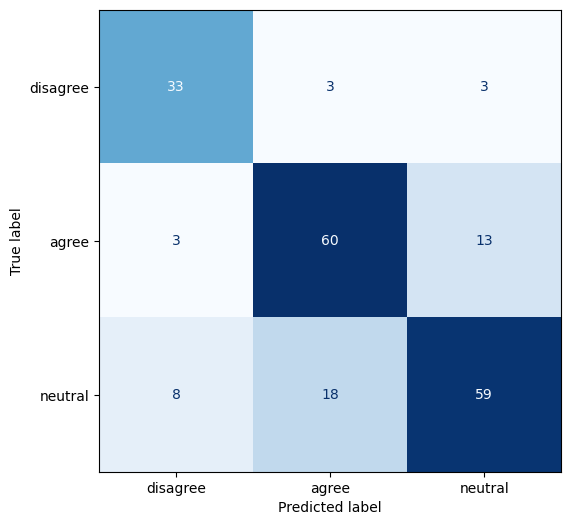

              precision    recall  f1-score   support

    disagree       0.75      0.85      0.80        39
       agree       0.74      0.79      0.76        76
     neutral       0.79      0.69      0.74        85

    accuracy                           0.76       200
   macro avg       0.76      0.78      0.77       200
weighted avg       0.76      0.76      0.76       200



In [81]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

y_pred = get_y_pred(model_name, folder_path)
y_true = get_y_true(model_name)
labels = list(label2id.keys())

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False)

plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [82]:

log_path = folder_path / 'trainer_state.json'
if not log_path.exists():
    raise FileNotFoundError("'trainer_state.json' not found.")

with open(log_path) as file:
    log = json.load(file)

# Collect metrics per epoch
log_metrics = {}
for metric in ['eval_f1', 'eval_accuracy', 'eval_loss', 'loss']:
    log_metrics[metric] = {entry['epoch']: entry[metric] for entry in log['log_history'] if metric in entry}

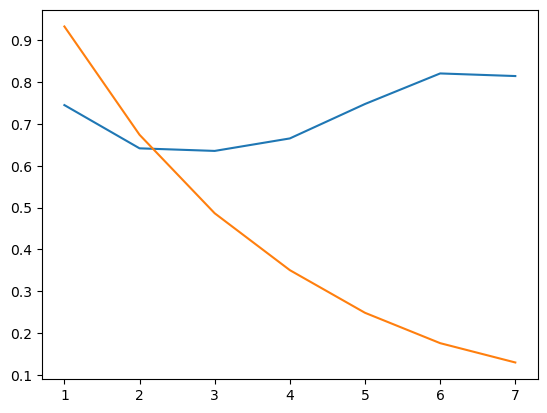

In [112]:
fig, ax = plt.subplots()

for metric in ['eval_loss', 'loss']:
    ax.plot( log_metrics[metric].keys(), log_metrics[metric].values() )

### Illustrate learning rate schedule

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


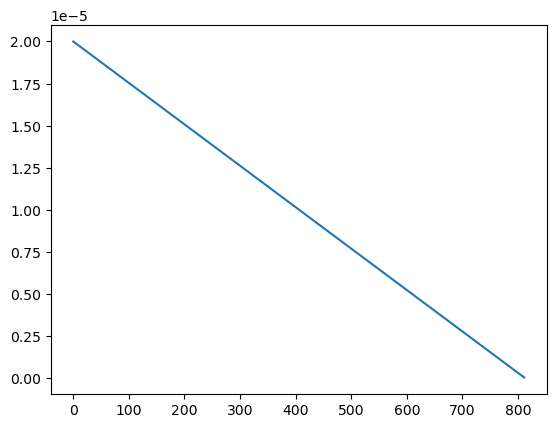

In [79]:
from torch.utils.data import RandomSampler, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

model = AutoModelForSequenceClassification.from_pretrained(models['bert_base_full']['ckpt'], num_labels=3)

train_sampler = RandomSampler(models['bert_base_full']['dataset_enc']['train'])
train_dataloader = DataLoader(models['bert_base_full']['dataset_enc']['train'], sampler=train_sampler, batch_size=16)

grad_accum_steps = 1
n_epochs = 7
t_total = len(train_dataloader) // grad_accum_steps * n_epochs

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-6)                                              # $
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=t_total) # $

lrs=[]
for i in range(t_total):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(lrs);